# Gabor filter interactive example

*This example is based on the code of the [sample](https://github.com/opencv/opencv/blob/master/samples/python/gabor_threads.py) from OpenCV repository*


## Theory

What is a Gabor filter ? Following [wiki](https://en.wikipedia.org/wiki/Gabor_filter) :

> In image processing, a Gabor filter, named after Dennis Gabor, is a linear filter used for edge detection. Frequency and orientation representations of Gabor filters are similar to those of the human visual system, and they have been found to be particularly appropriate for texture representation and discrimination. In the spatial domain, a **2D Gabor filter is a Gaussian kernel function modulated by a sinusoidal plane wave**.

> In the complex form : 
> $$g(x,y;\lambda,\theta,\psi,\sigma,\gamma) = \exp\left(-\frac{x'^2+\gamma^2y'^2}{2\sigma^2}\right)\exp\left(i\left(2\pi\frac{x'}{\lambda}+\psi\right)\right)$$
> Real part :
> $$g(x,y;\lambda,\theta,\psi,\sigma,\gamma) = \exp\left(-\frac{x'^2+\gamma^2y'^2}{2\sigma^2}\right)\cos\left(2\pi\frac{x'}{\lambda}+\psi\right)$$
> Imaginary part :
> $$g(x,y;\lambda,\theta,\psi,\sigma,\gamma) = \exp\left(-\frac{x'^2+\gamma^2y'^2}{2\sigma^2}\right)\sin\left(2\pi\frac{x'}{\lambda}+\psi\right)$$
> where
> $$x' = x \cos\theta + y \sin\theta\,$$
> and
> $$y' = -x \sin\theta + y \cos\theta\, $$

In [1]:
%matplotlib notebook
import numpy as np
import matplotlib.pylab as plt

from math import pi

Draw the form of the Gabor filter. 

*We use `interact` from `jupyter`. See the warnings in the console, if there is no slider in the interactive mode.*

In [2]:
x = np.arange(-3.0, 3.0, 0.005)
y = np.arange(-3.0, 3.0, 0.005)

lambd = 0.5
theta = 0.3
psi = 0.25
sigma = 0.15
gamma = 0.75

def gabor_func(x, y, l, t, p, s, g):
    xp = x * np.cos(t) + y * np.sin(t)
    yp = - x * np.sin(t) + y * np.cos(t)
    return np.exp(-(xp**2 + g**2 * yp**2)/(2.0*s**2)) * np.exp(1j * (2.0*pi * xp / l + p))

<IPython.core.display.Javascript object>


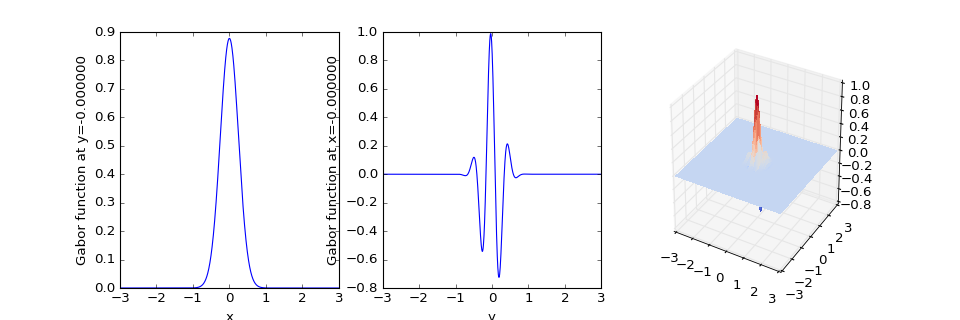

<function __main__.interactive_gabor_plot>

In [3]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from ipywidgets import interact, FloatSlider

xgrid, ygrid = np.meshgrid(x, y)

fig = None
def interactive_gabor_plot(lambd, theta, psi, sigma, gamma):
    zgrid = gabor_func(xgrid, ygrid, lambd, theta, psi, sigma, gamma)
    gabor_real = np.real(zgrid)
    
    global fig
    if fig is not None: plt.close(fig)
    fig = plt.figure(figsize=(12,4))
    ax = fig.add_subplot(131)
    ax.plot(xgrid[0,:], gabor_real[:, len(ygrid)/2])
    plt.xlabel("x")
    plt.ylabel("Gabor function at y=%f" % (ygrid[len(ygrid)/2, 0]))

    ax = fig.add_subplot(132)
    ax.plot(ygrid[:,0], gabor_real[len(xgrid)/2, :])
    plt.xlabel("y")
    plt.ylabel("Gabor function at x=%f" % (xgrid[0, len(xgrid)/2]))

    ax = fig.add_subplot(133, projection='3d')
    ax.plot_surface(xgrid, ygrid, gabor_real, cmap=cm.coolwarm, linewidth=0, antialiased=False)

    
interact(interactive_gabor_plot,           
         lambd=FloatSlider(value=0.5, min=0.001, max=5.0, continuous_update=False), 
         theta=FloatSlider(value=0.0, min=-pi, max=pi, continuous_update=False), 
         psi=FloatSlider(value=0.5, min=-pi, max=pi, continuous_update=False), 
         sigma=FloatSlider(value=0.25, min=0.1, max=5.0, continuous_update=False),
         gamma=FloatSlider(value=1.0, min=0.0, max=15.0, continuous_update=False))


Recall the form of the Gabor filter : 

$$g(x,y;\lambda,\theta,\psi,\sigma,\gamma) = \exp\left(-\frac{x'^2+\gamma^2y'^2}{2\sigma^2}\right)\exp\left(i\left(2\pi\frac{x'}{\lambda}+\psi\right)\right)$$
where
$x' = x \cos\theta + y \sin\theta\,$ and $y' = -x \sin\theta + y \cos\theta\, $

## Computer vision application

Now let us see how does it transform the images

In [4]:
import cv2

In [51]:
filename = "data/baboon.jpg"    
img = cv2.imread(filename)
assert img is not None, "File is not found"

img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

Setup a Gabor kernel using opencv function `cv2.getGaborKernel` 

> Help on built-in function getGaborKernel:
> getGaborKernel(...)
>    getGaborKernel(ksize, sigma, theta, lambd, gamma[, psi[, ktype]]) -> retval

In [46]:
ksize = 31
kernelX = cv2.getGaborKernel((ksize, ksize), 4.0, 0.0, 10.0, 0.5, 0, ktype=cv2.CV_32F)
kernelX /= 1.5*kernelX.sum()

kernelY = cv2.getGaborKernel((ksize, ksize), 4.0, pi/2, 10.0, 0.5, 0, ktype=cv2.CV_32F)
kernelY /= 1.5*kernelY.sum()

<IPython.core.display.Javascript object>


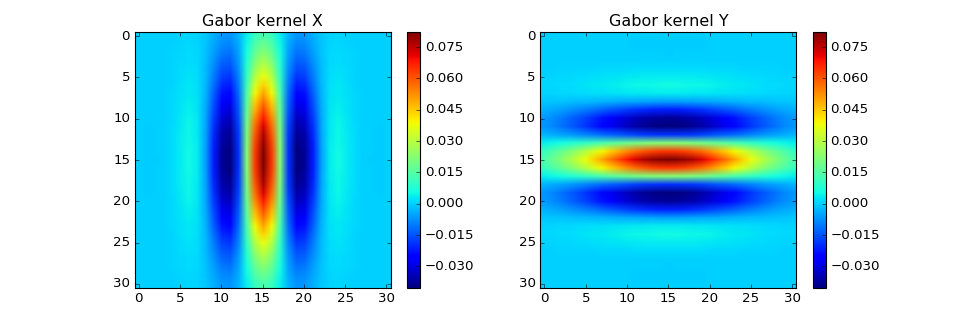

In [47]:
plt.figure(figsize=(12,4))
plt.subplot(121)
plt.title("Gabor kernel X")
plt.imshow(kernelX)
plt.colorbar()
plt.subplot(122)
plt.title("Gabor kernel Y")
plt.imshow(kernelY)
plt.colorbar()

In [48]:
gab_x_gray = cv2.filter2D(gray, cv2.CV_32FC1, kernelX)
gab_y_gray = cv2.filter2D(gray, cv2.CV_32FC1, kernelY)
gab_abs_gray = cv2.magnitude(gab_x_gray, gab_y_gray)

<IPython.core.display.Javascript object>


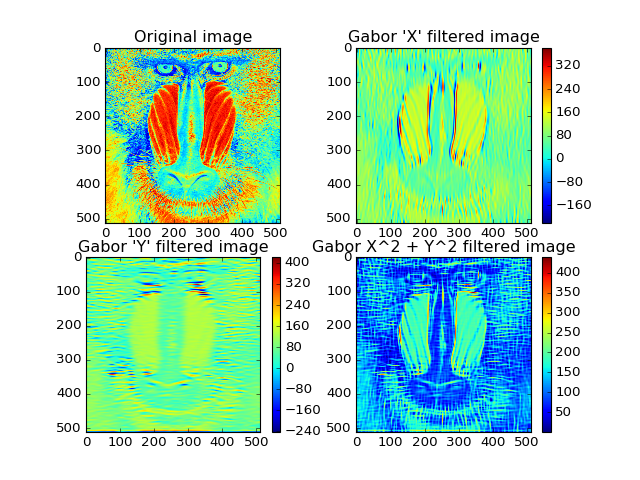

In [49]:
plt.figure()
plt.subplot(221)
plt.title("Original image")
plt.imshow(gray)
plt.subplot(222)
plt.title("Gabor 'X' filtered image")
plt.imshow(gab_x_gray)
plt.colorbar()
plt.subplot(223)
plt.title("Gabor 'Y' filtered image")
plt.imshow(gab_y_gray)
plt.colorbar()
plt.subplot(224)
plt.title("Gabor X^2 + Y^2 filtered image")
plt.imshow(gab_abs_gray)
plt.colorbar()

We can use multiple Gabor filter convolutions to get Fractalius-like image effect (http://www.redfieldplugins.com/filterFractalius.htm)

In [63]:
import os 

test_images = []
for filename in os.listdir("data"):
    p = os.path.join("data", filename)
    if not os.path.isfile(p):
        continue
    i = cv2.imread(p)
    i = cv2.cvtColor(i, cv2.COLOR_RGB2BGR)
    test_images.append(i)

<IPython.core.display.Javascript object>


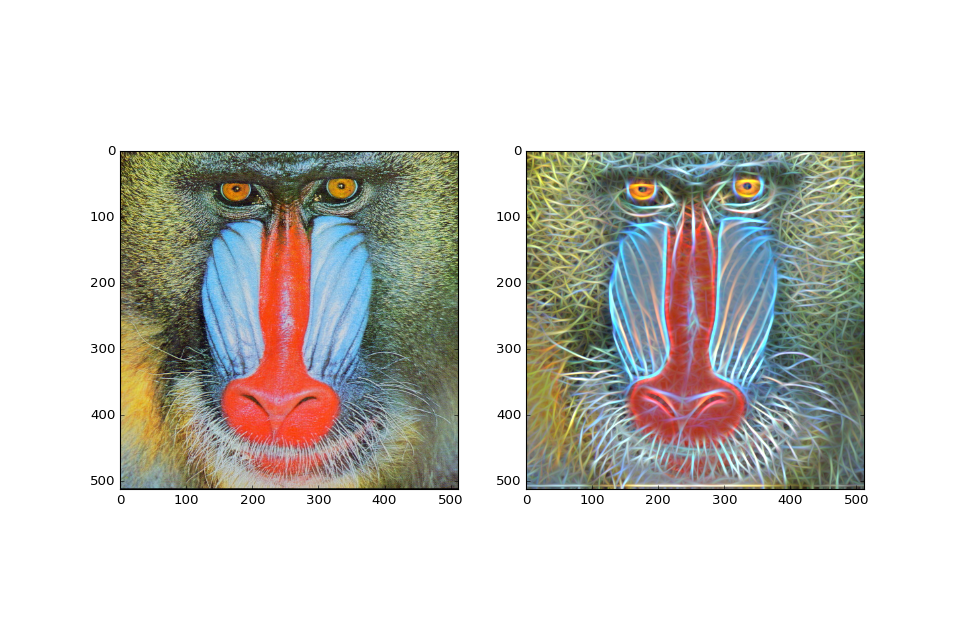

In [68]:
from ipywidgets import interact, IntSlider

def build_kernels(ksize, nb):
    kernels = []
    for theta in np.arange(0.0, pi + 0.01, pi/float(nb)):
        k = cv2.getGaborKernel((ksize, ksize), 4.0, theta, 10.0, 0.5, 0, ktype=cv2.CV_32F)
        k /= 1.5*k.sum()
        kernels.append(k)
    return kernels

def process(_img, kernels):
    out = np.zeros_like(_img)
    for k in kernels:
        fimg = cv2.filter2D(_img, cv2.CV_8UC3, k)
        out = np.maximum(out, fimg)
    return out

def interactive_effect(image_index, ksize, nb):
    kernels = build_kernels(ksize, nb)
    out = process(test_images[image_index], kernels)
    plt.figure(figsize=(12,8))
    plt.subplot(121)
    plt.imshow(test_images[image_index])
    plt.subplot(122)
    plt.imshow(out)   
    
interact(interactive_effect,  
         image_index=IntSlider(min=0, max=len(test_images)-1, value=2, continuous_update=False),
         ksize=IntSlider(min=1, max=51, step=2, value=31, continuous_update=False), 
         nb=IntSlider(min=2, max=32, step=1, value=16, continuous_update=False))